## Import Libraries

In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2


In [109]:
# Dataset paths
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'

In [110]:
# Image Parameters
BATCH_SIZE = 28
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Dataset Preprocessing

In [111]:
# Rescaling pixel values to [0, 1] for normalization
dataRescale = ImageDataGenerator(rescale=1./255)

# Augmenting training data with transformations
dataAugment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.7, 1.2),
)

### Load and apply preprocessing

In [112]:
# Creating data generators for train, validation, and test datasets
train_dataset_gen = dataRescale.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_dataset_gen = dataRescale.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Augmenting train dataset for additional variety
train_augmented = dataAugment.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 2560 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 2560 images belonging to 8 classes.


### Convert ImageDataGenerator to tf.data.Dataset

In [113]:
# Function to convert a generator to a TFDS
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32), 
        output_shapes=(
            (None, IMG_HEIGHT, IMG_WIDTH, 3),
            (None, len(generator.class_indices)) 
        )
    )

In [114]:
# Converting datasets to TensorFlow datasets
train_dataset_augmented = generator_to_tf_dataset(train_augmented)
train_dataset = generator_to_tf_dataset(train_dataset_gen)
val_dataset = generator_to_tf_dataset(val_dataset_gen)

In [115]:
# Combine original and augmented train images
train_dataset = train_dataset.concatenate(train_dataset_augmented)

# Prefetch
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [116]:
# Displaying a batch of data from the training dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (28, 224, 224, 3)
Label batch shape: (28, 8)


### Visualizing data augmentation results

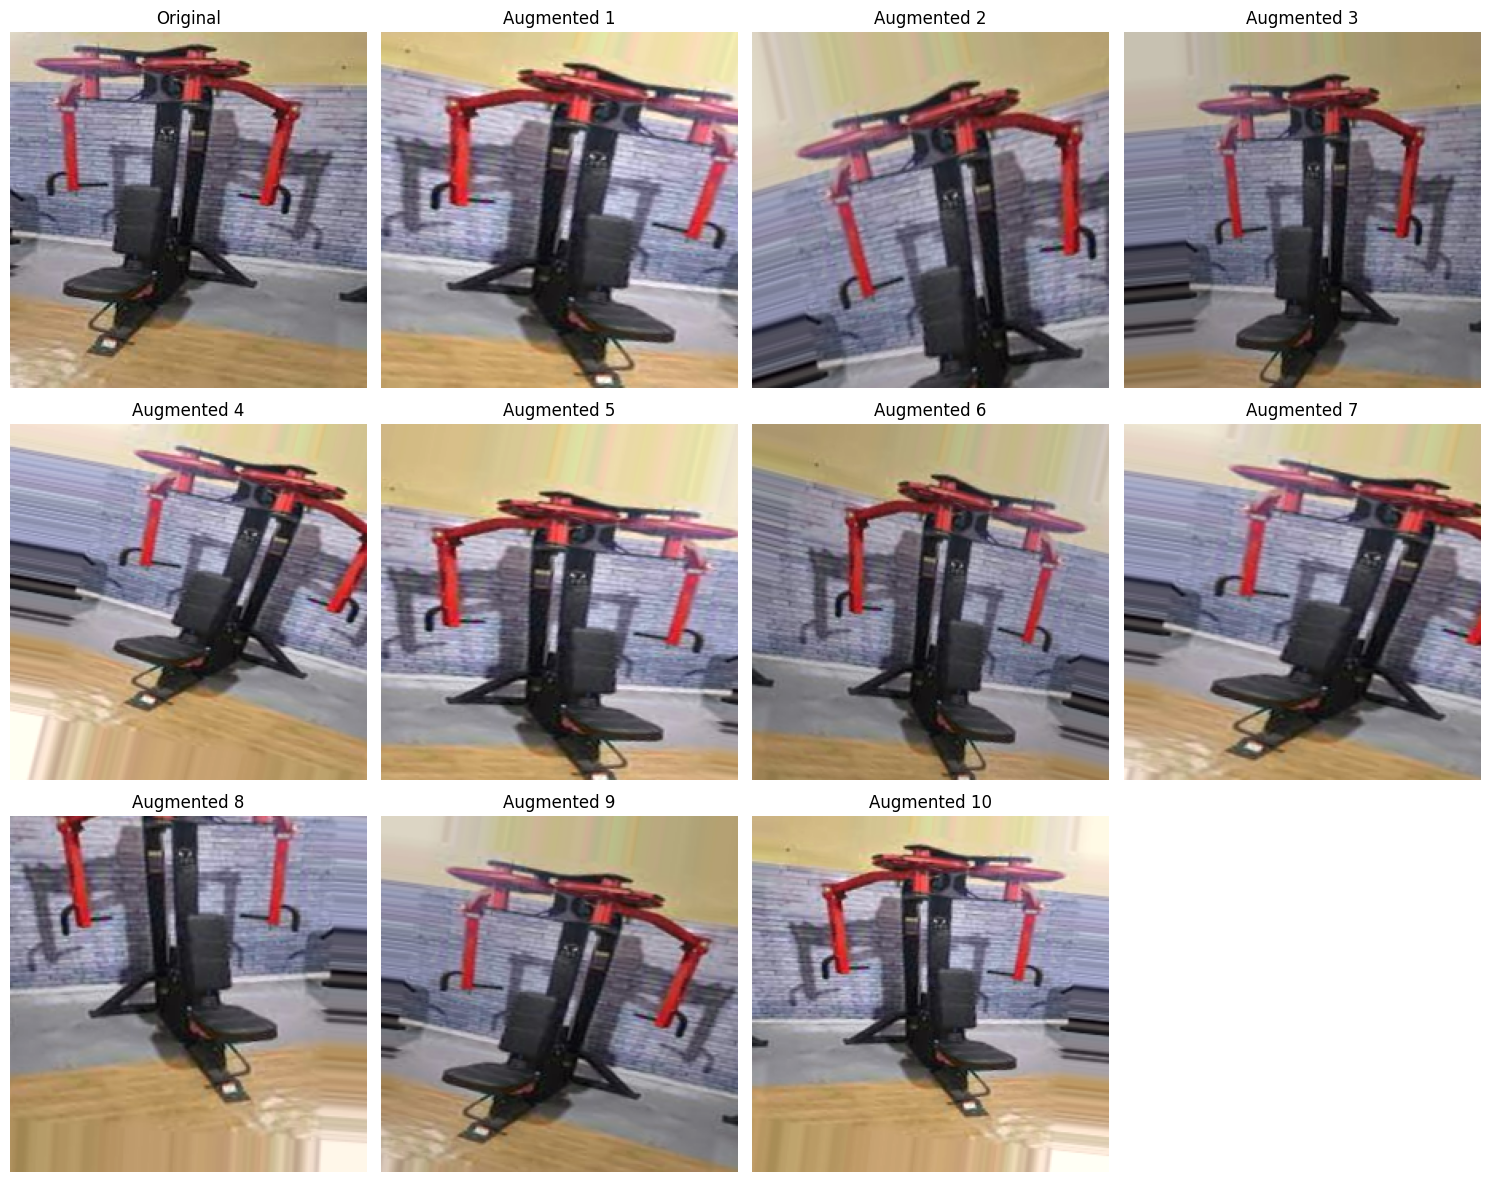

In [117]:
# Augmented sample
image = load_img('../dataset/train/Chest Fly Machine/train_chest_fly_machine12.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
image_array = img_to_array(image)
plt.figure(figsize=(15, 12)) 

# Show the original image
plt.subplot(3, 4, 1) 
plt.imshow(image_array.astype('uint8'))
plt.title("Original")
plt.axis('off')

# Prepare the image for augmentation
image_array = np.expand_dims(image_array, axis=0)

# Generate augmented images
augmented_images = dataAugment.flow(image_array, batch_size=1)

# Plot augmented images
for i in range(10):  
    augmented_image_array = next(augmented_images)[0]
    augmented_image_array = np.clip(augmented_image_array, 0, 1)  
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image_array)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout() 
plt.show()

# Modeling

In [118]:
# Load Pre-Trained MobileNetV2 Model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.summary(show_trainable=True, expand_nested=True)

Model: "mobilenetv2_1.00_224"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                Y          
                                )                                                                            
                                                                                                             
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']          

## Fine Tuning

In [119]:
# Freeze Selected Layer
freeze_to_layer = len(base_model.layers)
for layer in base_model.layers[:freeze_to_layer]:
      layer.trainable = False

In [120]:
# Define the custom model
def custom_model():
    input_layer = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    output_layer = tf.keras.layers.Dense(8, activation=tf.nn.softmax, kernel_regularizer=regularizers.L2(0.02))(x)
    
    cust_model = Model(inputs=input_layer, outputs=output_layer)
    return cust_model

In [121]:
# Instantiate and compile the model
model_ft = custom_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ft.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,  # Stop if val_loss doesn't improve for 7 epochs
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Wait 3 epochs before reducing learning rate
    min_lr=1e-6,  # Set minimum learning rate
    verbose=1
)

# Train the model
history = model_ft.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=120,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/120
184/184 [==============================] - 33s 38ms/step - loss: 15.3102 - accuracy: 0.1904 - val_loss: 13.0476 - val_accuracy: 0.5906 - lr: 1.0000e-04
Epoch 2/120
184/184 [==============================] - 29s 33ms/step - loss: 13.7827 - accuracy: 0.3391 - val_loss: 12.0899 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 3/120
184/184 [==============================] - 29s 33ms/step - loss: 12.8141 - accuracy: 0.4371 - val_loss: 11.3651 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 4/120
184/184 [==============================] - 30s 33ms/step - loss: 12.0317 - accuracy: 0.4912 - val_loss: 10.7510 - val_accuracy: 0.8031 - lr: 1.0000e-04
Epoch 5/120
184/184 [==============================] - 31s 34ms/step - loss: 11.2817 - accuracy: 0.5574 - val_loss: 10.1920 - val_accuracy: 0.8094 - lr: 1.0000e-04
Epoch 6/120
184/184 [==============================] - 30s 33ms/step - loss: 10.5565 - accuracy: 0.6111 - val_loss: 9.6341 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 7/120
184/1

In [122]:
model_ft.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                           

### Plotting Training and Validation Accuracy

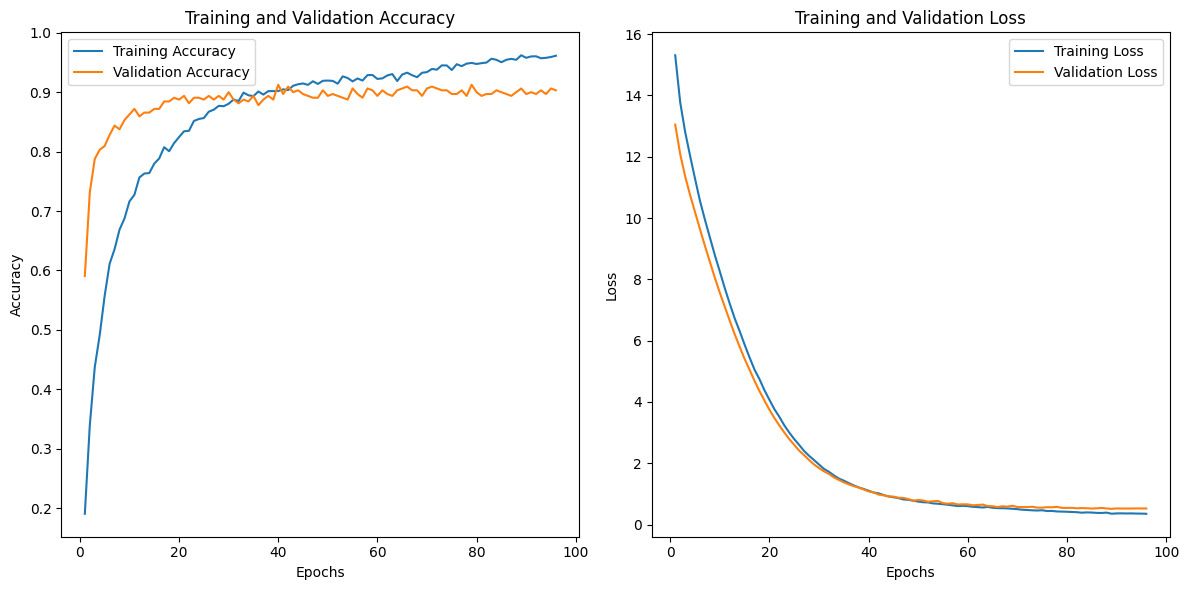

In [123]:
# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Defining the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Save Model

In [124]:
model_ft.save('../model/model_ft.h5')

## Convert Model

In [137]:
# Load the pre-trained model in .h5 format
model = tf.keras.models.load_model('../model/model_ft.h5')

# Export the model to the SavedModel format for further conversion
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir=export_dir)

# Convert the model to the TensorFlow Lite format with default optimizations
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Apply default optimizations (removes any deprecated optimizations warning)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a representative dataset generator function (if using full integer quantization)
def representative_data_gen():
    # Example: Use random data for the representative dataset (replace with real data)
    for _ in range(100):
        yield [np.random.random_sample((1, 224, 224, 3)).astype(np.float32)]

# Provide the representative dataset for full integer quantization
converter.representative_dataset = representative_data_gen

# Use INT8 quantization for weights and activations
converter.target_spec.supported_types = [tf.int8]

# Set input and output types to int8 for quantization
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Perform the conversion to TensorFlow Lite format
tflite_model = converter.convert()

# Specify the path to save the .tflite file
output_dir = '../model'
output_file = 'model_ft_quantized.tflite'

# Ensure the target directory exists; create it if not
os.makedirs(output_dir, exist_ok=True)

# Save the converted .tflite model file
tflite_model_file_path = os.path.join(output_dir, output_file)
with open(tflite_model_file_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved at: {tflite_model_file_path}")

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


Model saved at: ../model\model_ft_quantized.tflite
